In [2]:
import os
import git
from pathlib import Path

from typing import List
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display
import plotly.graph_objects as go
from IPython.display import clear_output
import pylustrator

ROOT_DIR =  Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
SAVE_FIGS = True
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(os.path.join(ROOT_DIR, "results", "combined_results"))
np.random.seed(0)
plots_path = os.path.join(ROOT_DIR, "poster", "plots")

In [3]:
def variance_prior(r, eta, scale=1):
    beta = (eta+1.5)/r
    var_prior = scale * scipy.special.gamma(beta + 1/r)/scipy.special.gamma(beta)
    return var_prior

def kurtosis_prior(r, eta, fisher=True):
    beta = (eta+1.5)/r
    kurtosis = 3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2 
    if fisher:
        return kurtosis - 3
    else:
        return kurtosis 

fixed_palette = {
    'gray': 'xkcd:gray',
    'green': 'xkcd:shamrock green',
    'red': 'xkcd:light red',
    'blue': 'xkcd:blue',
}


def find_master_dfs(root_dir: str) -> List[str]:
    root_path = Path(root_dir)
    if not root_path.exists():
        raise FileNotFoundError(f"Directory not found: {root_dir}")

    master_df_paths = []
    for current_dir, _, files in os.walk(root_path):
        if 'master_df.csv' in files:
            master_df_path = Path(os.path.join(current_dir, 'master_df.csv'))
            master_df_paths.append(str(master_df_path.absolute()))
    return master_df_paths

relevant_cols = ['group', 'obs_var', 'var_lower', 'var_upper', 'obs_kurt', 'kurt_lower',
       'kurt_upper', 'total_samples', 'initial_r', 'initial_eta',
       'kstest_stat_initial', 'kstest_stat_cutoff_0.05', 'kstest_stat_eta0',
       'best_r_eta0', 'best_r', 'best_eta', 'kstest_stat_best', 'iter1_r',
       'iter1_eta', 'kstest_stat_iter1', 'n_pval_0.05', 'param_gaussian',
       'kstest_stat_gaussian', 'kstest_pval_gaussian', 'param_laplace',
       'kstest_stat_laplace', 'kstest_pval_laplace', 'param_t',
       'kstest_stat_t', 'kstest_pval_t', 'kstest_pval_gengamma', 'dataset', 'transform', 'size', 'channel']

all_paths = find_master_dfs('..\case-studies')
all_master_dfs = []

for path in all_paths:
    dataset, transform, size, channel, _, _ = Path(path).parts[-6:]
    master_df = pd.read_csv(path)
    master_df = master_df.rename(columns={master_df.columns[0]: 'group'})#.set_index('group')
    master_df['dataset'] = dataset
    master_df['transform'] = transform
    master_df['size'] = size
    master_df['channel'] = channel

    all_master_dfs.append(master_df[relevant_cols])
    
main_df = pd.concat(all_master_dfs)
main_df['prior_var'] = main_df.apply(lambda row : variance_prior(row.loc['best_r'], row.loc['best_eta']), axis = 1)
main_df['prior_kurt'] = main_df.apply(lambda row : kurtosis_prior(row.loc['best_r'], row.loc['best_eta']), axis = 1)
main_df['gaussian_kurt'] = np.zeros(main_df.shape[0])
main_df['laplace_kurt'] = 3*np.ones(main_df.shape[0])
main_df['best_beta'] = (main_df['best_eta'] + 1.5)/main_df['best_r'] 

frequency_map = pd.read_csv(os.path.join(ROOT_DIR, "transformed-data", "master-frequency-map.csv")).set_index(['dataset', 'transform', 'group'])
main_df = main_df.set_index(['dataset', 'transform', 'group']).merge(frequency_map, left_index = True, right_index=True).reset_index()
main_df

,dataset,transform,group,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,...,kstest_pval_t,kstest_pval_gengamma,size,channel,prior_var,prior_kurt,gaussian_kurt,laplace_kurt,best_beta,frequency
0,agriVision,fourier,2,3.389382e+08,1.963741e+08,5.527124e+08,421.841550,123.974430,696.238040,45000.0,...,1.382990e-14,1.040585e-02,batch0approx1e5,blue,8.662839e+07,17.410192,0.0,3.0,15.379747,0.008394
1,agriVision,fourier,5,1.737109e+08,1.001625e+08,3.273177e+08,628.030000,108.212240,1663.239500,117000.0,...,3.910420e-23,4.417691e-09,batch0approx1e5,blue,3.590489e+07,12.747080,0.0,3.0,16.190476,0.013218
2,agriVision,fourier,8,6.727504e+07,3.507278e+07,1.706153e+08,1363.730700,99.365600,3639.235800,189000.0,...,2.031100e-27,1.284655e-05,batch0approx1e5,blue,1.592314e+07,13.211559,0.0,3.0,15.000000,0.020181
3,agriVision,fourier,11,3.197149e+07,1.499865e+07,1.022867e+08,2698.317600,93.680930,4889.278000,495000.0,...,1.306900e-42,5.197276e-08,batch0approx1e5,blue,7.901878e+06,12.119417,0.0,3.0,14.662921,0.030472
4,agriVision,fourier,14,1.270560e+07,6.076386e+06,3.976188e+07,2654.295200,86.305040,4711.629400,1134000.0,...,1.516550e-83,7.405179e-12,batch0approx1e5,blue,3.491911e+06,9.826406,0.0,3.0,14.893617,0.046298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,spaceNet,wavelet,5,3.739722e+02,3.631603e+02,3.849922e+02,10.399796,7.744357,15.153512,1149538.0,...,0.000000e+00,0.000000e+00,approx1e5,red,1.988715e+03,225.923873,0.0,3.0,2.368421,0.199222
283,spaceNet,wavelet,6,9.055869e+01,8.797025e+01,9.337066e+01,11.086198,8.393261,15.483007,4251250.0,...,0.000000e+00,0.000000e+00,approx1e5,red,2.538421e+02,66.899597,0.0,3.0,2.375000,0.249027
284,spaceNet,wavelet,7,2.086429e+01,2.013236e+01,2.165660e+01,18.333370,11.867616,29.351609,17005000.0,...,0.000000e+00,0.000000e+00,approx1e5,red,4.285132e+01,54.023663,0.0,3.0,1.750000,0.332036
285,spaceNet,wavelet,8,4.537877e+00,4.343649e+00,4.747077e+00,28.597766,17.033248,47.502076,68020000.0,...,0.000000e+00,0.000000e+00,approx1e5,red,3.270914e+00,19.010542,0.0,3.0,1.141553,0.498054


## How do we compare to other priors?

In [43]:
fontsize = 20
markersize = 10
labelsize = 20
markertypes = ['x', 'D', 'o', '+']
labels = ['GenGamma', 'Laplace', 'Gaussian', 'Student-t', r'$\alpha=0.05$']
points = [Line2D([0], [0], color='k', linestyle='', marker=m, markersize=10) for m in markertypes] + [Line2D([0], [0], color='k', linestyle='-', linewidth=2)]

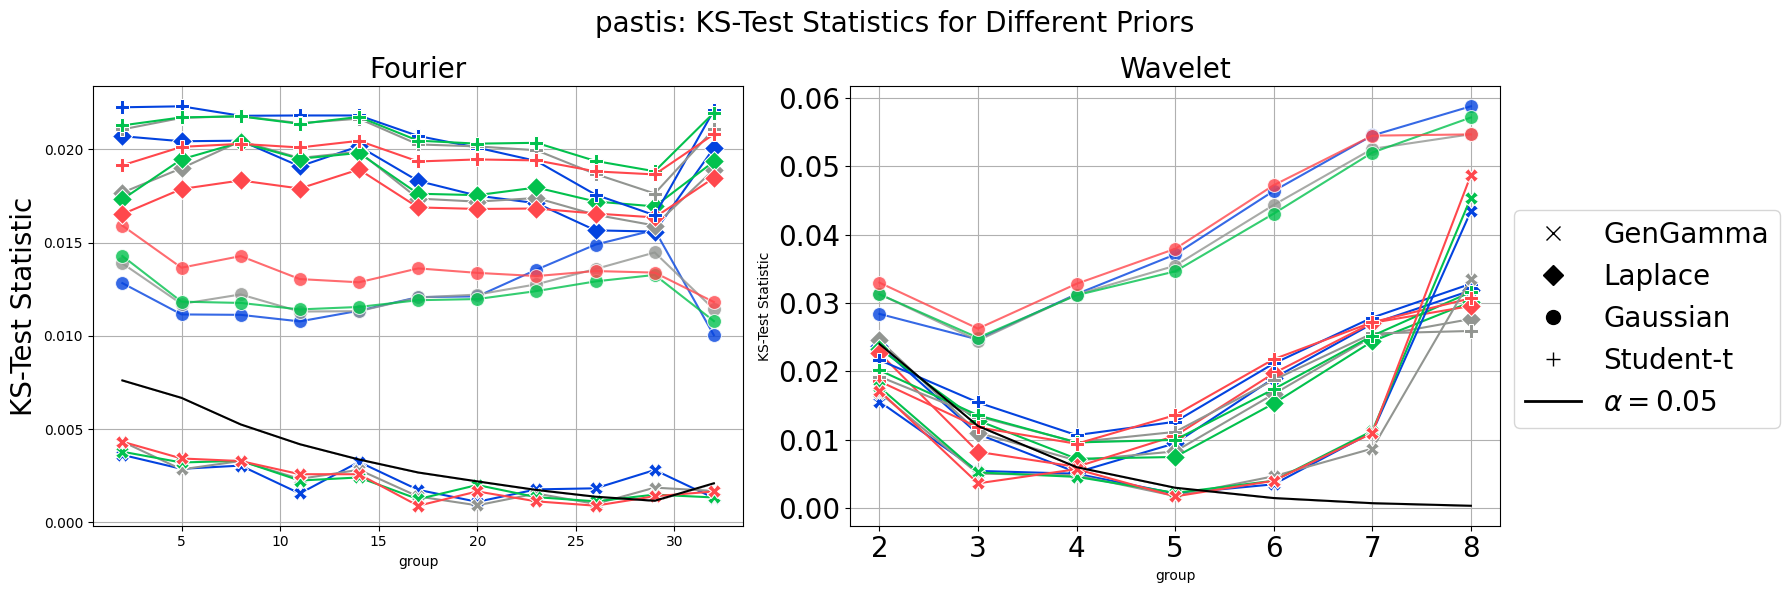

In [44]:
# Extract Common Legend
hue = 'channel'

dataset_name = 'pastis'
fixed_palette = {'gray': 'xkcd:gray','green': 'xkcd:shamrock green', 'red': 'xkcd:light red','blue': 'xkcd:blue'}

transform = 'fourier'
dataset_filter = (main_df['dataset'] == dataset_name)
transform_filter = (main_df['transform'] == transform)
temp = main_df[dataset_filter & transform_filter]

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle(f"{dataset_name}: KS-Test Statistics for Different Priors", fontsize=fontsize)

sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[0], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[0], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[0], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[0], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_cutoff_0.05', color='black', ax=axes[0])
axes[0].set_ylabel("KS-Test Statistic", fontsize = fontsize)
axes[0].legend(points, labels, fontsize = fontsize).set_visible(False)
axes[0].grid(True)
axes[0].set_title(f"Fourier", fontsize = fontsize)

transform = 'wavelet'
transform_filter = (main_df['transform'] == transform)
temp = main_df[dataset_filter & transform_filter]

sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[1], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[1], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[1], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[1], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_cutoff_0.05', color='black', ax=axes[1])
axes[1].set_ylabel("KS-Test Statistic")
axes[1].legend(points, labels, fontsize = fontsize, bbox_to_anchor = (1, 0.75))
axes[1].grid(True)
axes[1].set_title(f"Wavelet", fontsize = fontsize)
axes[1].tick_params(axis='both', which='major', labelsize=labelsize)
plt.tight_layout()
plt.show()
axes[1].legend()

if SAVE_FIGS:
    fig.figure.savefig(os.path.join(plots_path, f"ksstat_across_priors_legend.jpg"), dpi=1000, bbox_inches='tight')

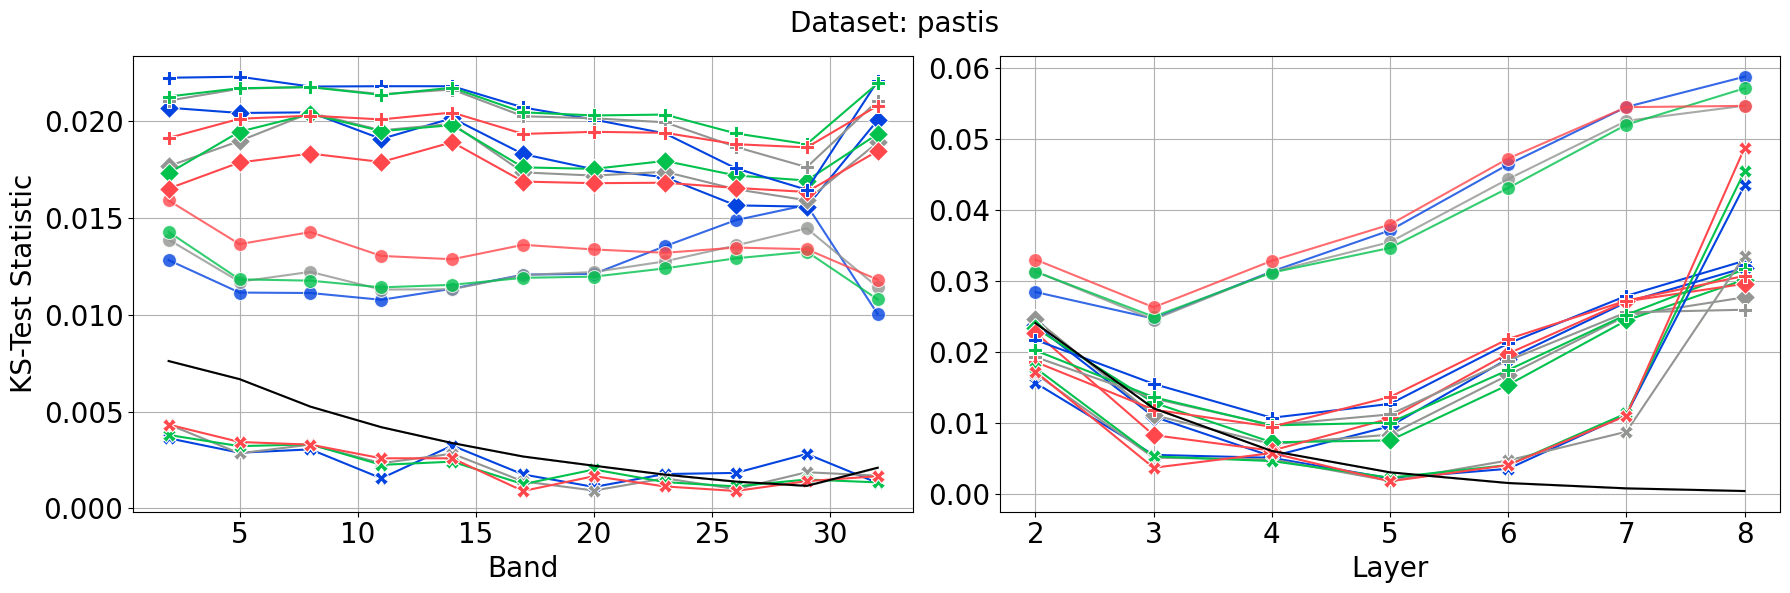

In [45]:
hue = 'channel'
dataset_name = 'pastis'
fixed_palette = {'gray': 'xkcd:gray','green': 'xkcd:shamrock green', 'red': 'xkcd:light red','blue': 'xkcd:blue'}

transform = 'fourier'
dataset_filter = (main_df['dataset'] == dataset_name)
transform_filter = (main_df['transform'] == transform)
temp = main_df[dataset_filter & transform_filter]

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle(f"Dataset: {dataset_name}", fontsize=fontsize)

sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[0], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[0], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[0], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[0], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_cutoff_0.05', color='black', ax=axes[0])
axes[0].set_xlabel("Band", fontsize=fontsize)
axes[0].set_ylabel("KS-Test Statistic", fontsize=fontsize)
axes[0].legend(points, labels, fontsize = 12).set_visible(False)
axes[0].grid(True)
# axes[0].set_title("Fourier", fontsize=fontsize)
axes[0].tick_params(axis='both', which='major', labelsize=fontsize)

transform = 'wavelet'
transform_filter = (main_df['transform'] == transform)
temp = main_df[dataset_filter & transform_filter]

sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[1], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[1], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[1], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[1], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_cutoff_0.05', color='black', ax=axes[1])
axes[1].set_xlabel("Layer", fontsize=fontsize)
axes[1].set_ylabel("", fontsize=fontsize)
axes[1].legend(points, labels, fontsize = 20, bbox_to_anchor = (1, 0.75)).set_visible(False)
axes[1].grid(True)
# axes[1].set_title("Wavelet", fontsize=fontsize)
axes[1].tick_params(axis='both', which='major', labelsize=fontsize)
plt.tight_layout()
plt.show()

if SAVE_FIGS:
    fig.figure.savefig(os.path.join(plots_path, f"ksstat_across_priors_{dataset_name}.jpg"), dpi=1000, bbox_inches='tight')

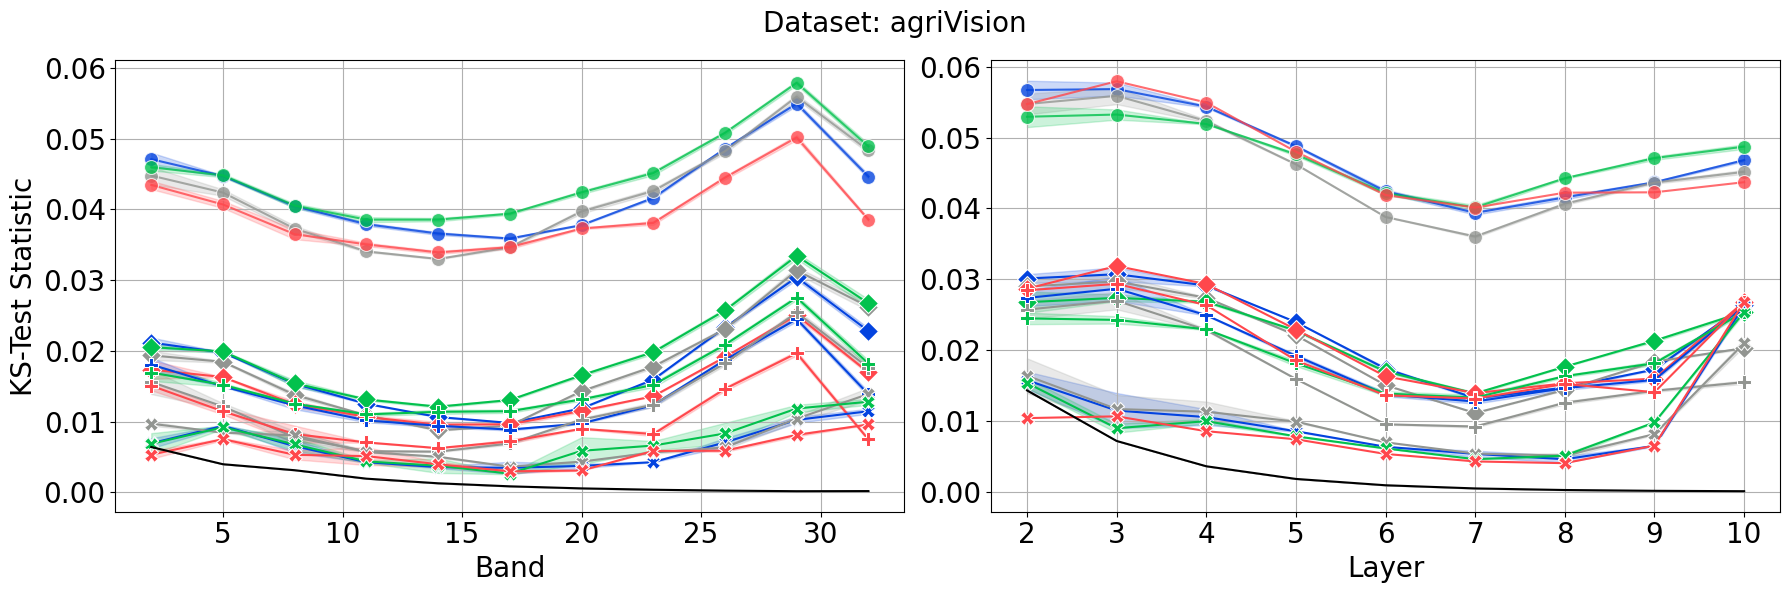

In [46]:
hue = 'channel'
dataset_name = 'agriVision'
fixed_palette = {'gray': 'xkcd:gray','green': 'xkcd:shamrock green', 'red': 'xkcd:light red','blue': 'xkcd:blue'}

transform = 'fourier'
dataset_filter = (main_df['dataset'] == dataset_name)
transform_filter = (main_df['transform'] == transform)
temp = main_df[dataset_filter & transform_filter]

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle(f"Dataset: {dataset_name}", fontsize=fontsize)

sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[0], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[0], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[0], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[0], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_cutoff_0.05', color='black', ax=axes[0])
axes[0].set_xlabel("Band", fontsize=fontsize)
axes[0].set_ylabel("KS-Test Statistic", fontsize=fontsize)
axes[0].legend(points, labels, fontsize = 12).set_visible(False)
axes[0].grid(True)
# axes[0].set_title("Fourier", fontsize=fontsize)
axes[0].tick_params(axis='both', which='major', labelsize=fontsize)

transform = 'wavelet'
transform_filter = (main_df['transform'] == transform)
temp = main_df[dataset_filter & transform_filter]

sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[1], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[1], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[1], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[1], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_cutoff_0.05', color='black', ax=axes[1])
axes[1].set_xlabel("Layer", fontsize=fontsize)
axes[1].set_ylabel("", fontsize=fontsize)
axes[1].legend(points, labels, fontsize = 20, bbox_to_anchor = (1, 0.75)).set_visible(False)
axes[1].grid(True)
# axes[1].set_title("Wavelet", fontsize=fontsize)
axes[1].tick_params(axis='both', which='major', labelsize=fontsize)
plt.tight_layout()
plt.show()

if SAVE_FIGS:
    fig.figure.savefig(os.path.join(plots_path, f"ksstat_across_priors_{dataset_name}.jpg"), dpi=1000, bbox_inches='tight')

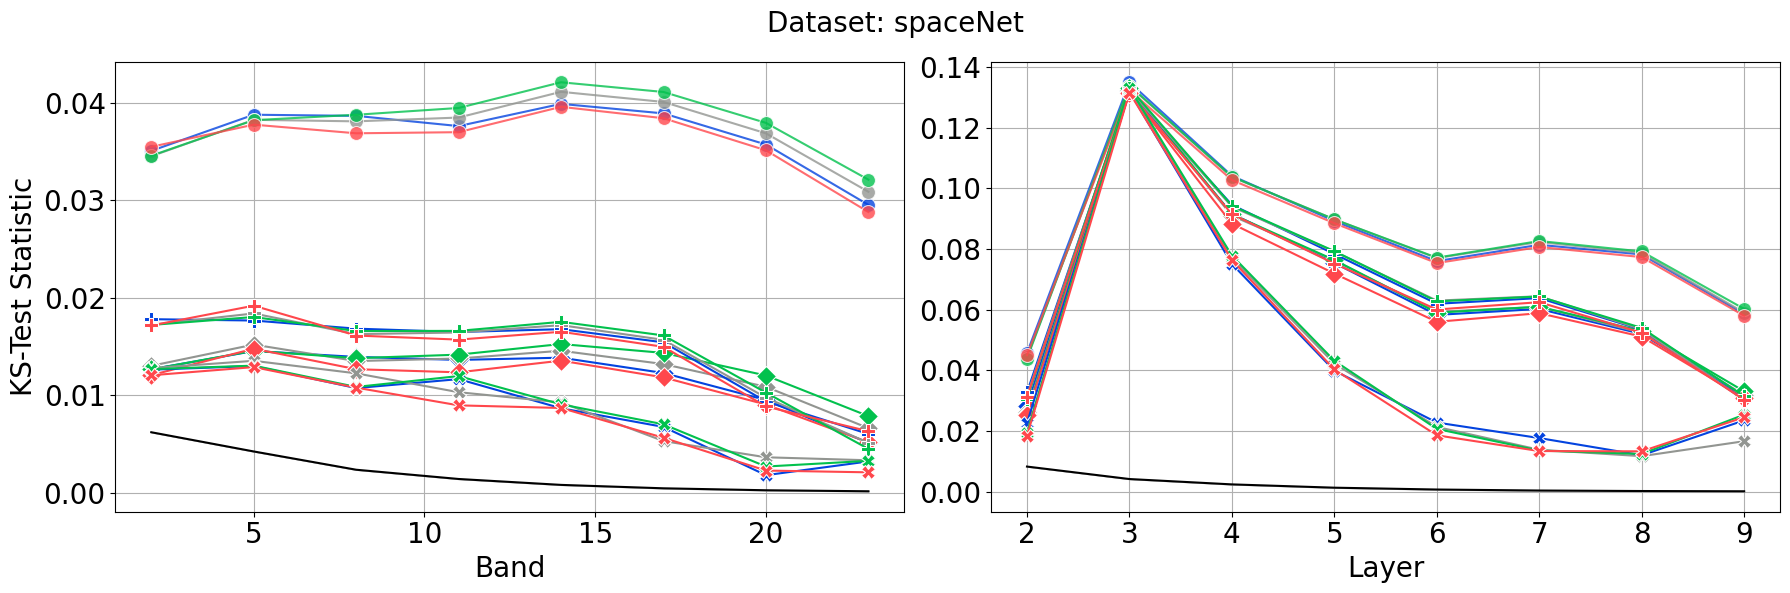

In [47]:
hue = 'channel'
dataset_name = 'spaceNet'
fixed_palette = {'gray': 'xkcd:gray','green': 'xkcd:shamrock green', 'red': 'xkcd:light red','blue': 'xkcd:blue'}

transform = 'fourier'
dataset_filter = (main_df['dataset'] == dataset_name)
transform_filter = (main_df['transform'] == transform)
temp = main_df[dataset_filter & transform_filter]

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle(f"Dataset: {dataset_name}", fontsize=fontsize)

sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[0], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[0], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[0], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[0], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_cutoff_0.05', color='black', ax=axes[0])
axes[0].set_xlabel("Band", fontsize=fontsize)
axes[0].set_ylabel("KS-Test Statistic", fontsize=fontsize)
axes[0].legend(points, labels, fontsize = 12).set_visible(False)
axes[0].grid(True)
# axes[0].set_title("Fourier", fontsize=fontsize)
axes[0].tick_params(axis='both', which='major', labelsize=fontsize)

transform = 'wavelet'
transform_filter = (main_df['transform'] == transform)
temp = main_df[dataset_filter & transform_filter]

sns.lineplot(data=temp, x='group', y='kstest_stat_gaussian', hue=hue, palette=fixed_palette, marker='o', alpha=0.8, ax=axes[1], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_laplace', hue=hue, palette=fixed_palette, marker='D', ax=axes[1], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_t', hue=hue, palette=fixed_palette, marker='P', ax=axes[1], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_best', hue=hue, palette=fixed_palette, marker='X', ax=axes[1], markersize = markersize)
sns.lineplot(data=temp, x='group', y='kstest_stat_cutoff_0.05', color='black', ax=axes[1])
axes[1].set_xlabel("Layer", fontsize=fontsize)
axes[1].set_ylabel("", fontsize=fontsize)
axes[1].legend(points, labels, fontsize = 20, bbox_to_anchor = (1, 0.75)).set_visible(False)
axes[1].grid(True)
# axes[1].set_title("Wavelet", fontsize=fontsize)
axes[1].tick_params(axis='both', which='major', labelsize=fontsize)
plt.tight_layout()
plt.show()

if SAVE_FIGS:
    fig.figure.savefig(os.path.join(plots_path, f"ksstat_across_priors_{dataset_name}.jpg"), dpi=1000, bbox_inches='tight')

## Where do these parameters lie?

In [4]:
fontsize = 20
markersize = 70
labelsize = 20

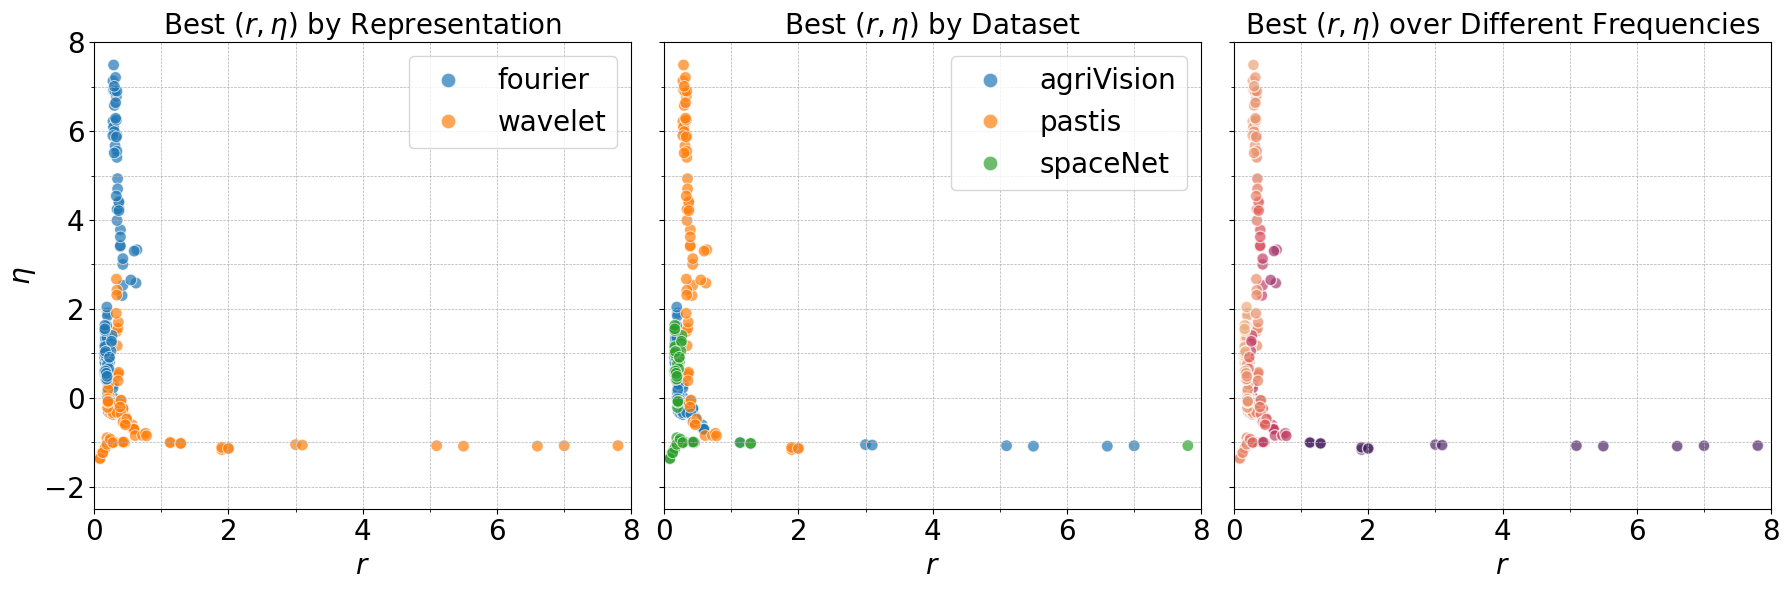

In [23]:
from matplotlib.ticker import MultipleLocator

colors = {
    'shaded_region': 'grey',
    'variance_level_set': 'green',
    'laplace': 'blue',
    'cauchy': 'xkcd:dark orange',
    'student_t': 'xkcd:dark orange',
    'axis_arrows': 'black',
    'annotation': 'black'
}

plot_config = {
    'x_limits': (0, 8),
    'y_limits': (-2.5, 8),
    'font_multiplier': 1,
    'font_addition': 5,
    'linewidth': 2,
    'figsize': (10, 6)
}

x_limits = plot_config['x_limits']
y_limits = plot_config['y_limits']
font_size = plot_config['font_multiplier']*12 + plot_config['font_addition']

label_r = r'$r$'
label_eta = r'$\eta$'
label_laplace = r'Laplace $(0, \frac{1}{\sqrt{2}})$'
label_student_t = r'Student t ($\nu=2$)'
label_cauchy = r'Cauchy (0, 1)'
label_variance_level_sets = 'Variance Level Sets'
label_previous_region_of_interest = 'Previous Region of Interest'
title_comparison = 'Comparison to Commonly Used Priors'

x_shade_roi = np.array([0, 4])
y_shade_roi = np.array([-0.1, 0.1])

temp = main_df
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for ax in (ax1, ax2, ax3):
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.yaxis.set_minor_locator(MultipleLocator(1))
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.set_xlabel(r'$r$', fontsize=fontsize)

    # x_shade = np.array([0, plot_config['x_limits'][1]])
    # y_shade = np.array([-1.5, -1.5])
    # ax.fill_between(x_shade, plot_config['y_limits'][0], y_shade, color=colors['shaded_region'], alpha=0.2)
    # ax.plot(x_shade, y_shade, 'k-', linewidth=1.5)

    # x_shade = np.array([plot_config['x_limits'][0], 0])
    # y_shade = np.array([-1.5, -1.5])
    # ax.fill_between(x_shade, y_shade, plot_config['y_limits'][1], color=colors['shaded_region'], alpha=0.2)
    # ax.plot(x_shade, y_shade, 'k-', linewidth=1.5)

sns.scatterplot(data=temp, x='best_r', y='best_eta', hue='transform', ax=ax1, alpha=0.7, s=markersize)
ax1.set_title(r'Best ($r, \eta$) by Representation', fontsize=fontsize)
ax1.set_ylabel(r'$\eta$', fontsize=fontsize)
ax1.tick_params(axis='both', which='major', labelsize=labelsize)

sns.scatterplot(data=temp, x='best_r', y='best_eta', hue='dataset', ax=ax2, alpha=0.7, s=markersize)
ax2.set_title(r'Best ($r, \eta$) by Dataset', fontsize=fontsize)
ax2.set_ylabel('', fontsize=fontsize)
ax2.tick_params(axis='both', which='major', labelsize=labelsize)

# Create scatter plot with colormap instead of discrete colors
scatter = ax3.scatter(temp['best_r'], temp['best_eta'], 
                     c=temp['frequency'], 
                     cmap='flare',
                     s=markersize, 
                     alpha=0.7, edgecolor='white')  # Set color scale range

# # Create smaller colorbar in the top right
# colorbar = plt.colorbar(scatter, ax=ax3, 
#                        fraction=0.1,     # Make colorbar smaller
#                        pad=-0,           # Adjust spacing from plot
#                        location='right',
#                        aspect=6)           # Make colorbar more compact
# colorbar.set_label('Frequency', fontsize=fontsize)
# colorbar.ax.tick_params(labelsize=labelsize)

ax3.set_title(r'Best ($r, \eta$) over Different Frequencies', fontsize=fontsize)
ax3.set_ylabel('', fontsize=fontsize)
ax3.tick_params(axis='both', which='major', labelsize=labelsize)

ax1.legend(markerscale=1.25, fontsize=fontsize)
ax2.legend(markerscale=1.25, fontsize=fontsize)
plt.tight_layout()
plt.show()

if SAVE_FIGS:
    fig.savefig(os.path.join(plots_path, "best_r_eta_1.jpg"), dpi=1000, bbox_inches='tight')

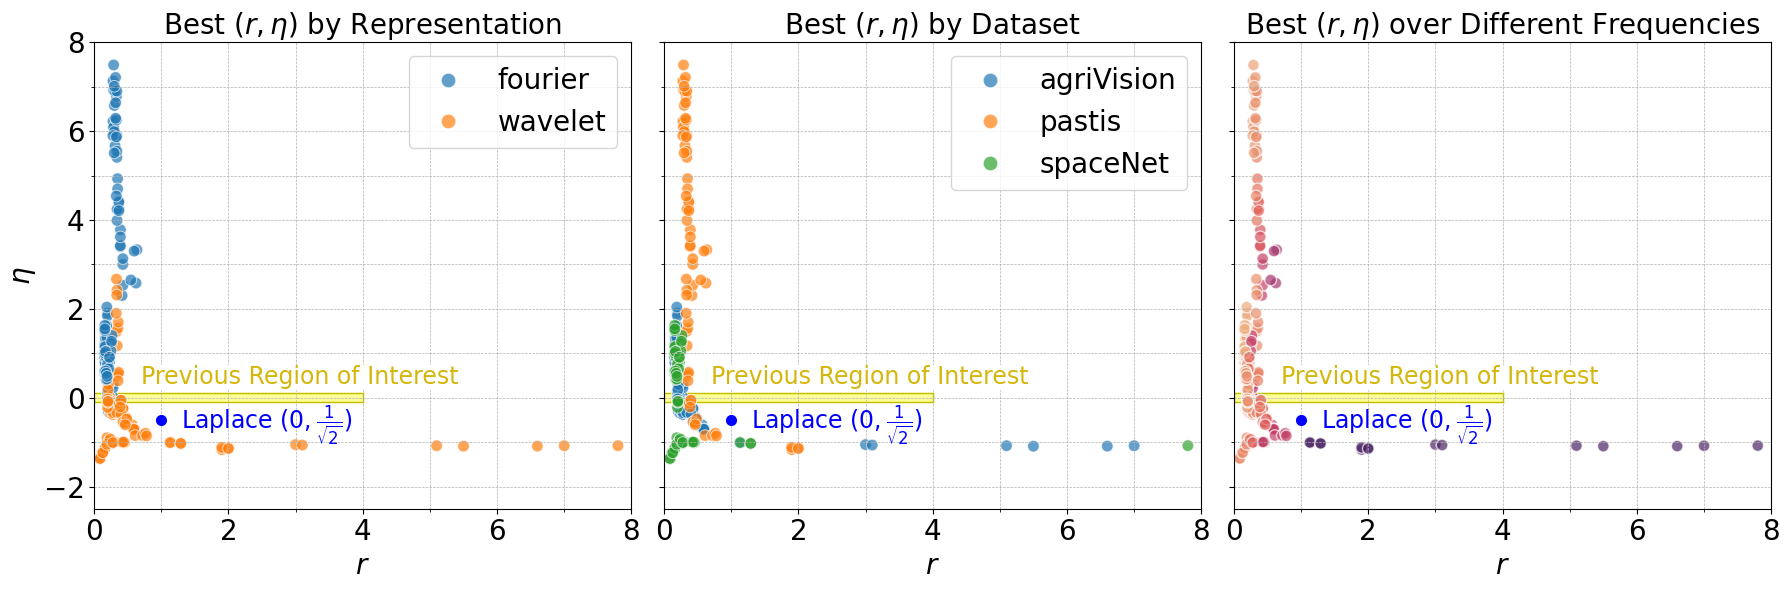

In [24]:
from matplotlib.ticker import MultipleLocator

colors = {
    'shaded_region': 'grey',
    'variance_level_set': 'green',
    'laplace': 'blue',
    'cauchy': 'xkcd:dark orange',
    'student_t': 'xkcd:dark orange',
    'axis_arrows': 'black',
    'annotation': 'black'
}

plot_config = {
    'x_limits': (0, 8),
    'y_limits': (-2.5, 8),
    'font_multiplier': 1,
    'font_addition': 5,
    'linewidth': 2,
    'figsize': (10, 6)
}

x_limits = plot_config['x_limits']
y_limits = plot_config['y_limits']
font_size = plot_config['font_multiplier']*12 + plot_config['font_addition']

label_r = r'$r$'
label_eta = r'$\eta$'
label_laplace = r'Laplace $(0, \frac{1}{\sqrt{2}})$'
label_student_t = r'Student t ($\nu=2$)'
label_cauchy = r'Cauchy (0, 1)'
label_variance_level_sets = 'Variance Level Sets'
label_previous_region_of_interest = 'Previous Region of Interest'
title_comparison = 'Comparison to Commonly Used Priors'

x_shade_roi = np.array([0, 4])
y_shade_roi = np.array([-0.1, 0.1])

temp = main_df
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6), sharey=True)  # Adjusted total figsize

for ax in (ax1, ax2, ax3):
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.yaxis.set_minor_locator(MultipleLocator(1))
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.set_xlabel(r'$r$', fontsize=fontsize)

    # x_shade = np.array([0, plot_config['x_limits'][1]])
    # y_shade = np.array([-1.5, -1.5])
    # ax.fill_between(x_shade, plot_config['y_limits'][0], y_shade, color=colors['shaded_region'], alpha=0.2)
    # ax.plot(x_shade, y_shade, 'k-', linewidth=1.5)

    # x_shade = np.array([plot_config['x_limits'][0], 0])
    # y_shade = np.array([-1.5, -1.5])
    # ax.fill_between(x_shade, y_shade, plot_config['y_limits'][1], color=colors['shaded_region'], alpha=0.2)
    # ax.plot(x_shade, y_shade, 'k-', linewidth=1.5)

    # Add Laplace
    ax.scatter(1, -0.5, color=colors['laplace'], linewidth=plot_config['linewidth'], zorder=10)
    ax.annotate(label_laplace, xy=(plot_config['x_limits'][1], -1), xytext=(1.3, -0.7), 
        textcoords='data', color=colors['laplace'], fontsize=font_size, zorder=10)
    
    # Add narrow lightly shaded yellow region
    ax.fill_between(x_shade_roi, y_shade_roi[0], y_shade_roi[1], color='yellow', alpha=0.4, zorder=0)
    ax.plot(x_shade_roi, [y_shade_roi[0], y_shade_roi[0]], 'y-', linewidth=1, zorder=0)
    ax.plot(x_shade_roi, [y_shade_roi[1], y_shade_roi[1]], 'y-', linewidth=1, zorder=0)

    # Add vertical bounding lines
    ax.plot([x_shade_roi[0], x_shade_roi[0]], y_shade_roi, 'y-', linewidth=1, zorder=0)
    ax.plot([x_shade_roi[1], x_shade_roi[1]], y_shade_roi, 'y-', linewidth=1, zorder=0)

    # Add annotation for the shaded region
    ax.annotate(label_previous_region_of_interest, xy=(1.5, 0), xytext=(0.7, 0.3),
        textcoords='data', color='xkcd:dark yellow', fontsize=font_size,
        bbox=dict(facecolor='white', edgecolor='none', pad=0.5))
    



sns.scatterplot(data=temp, x='best_r', y='best_eta', hue='transform', ax=ax1, alpha=0.7, s=markersize)
ax1.set_title(r'Best ($r, \eta$) by Representation', fontsize=fontsize)
ax1.set_ylabel(r'$\eta$', fontsize=fontsize)
ax1.tick_params(axis='both', which='major', labelsize=labelsize)

sns.scatterplot(data=temp, x='best_r', y='best_eta', hue='dataset', ax=ax2, alpha=0.7, s=markersize)
ax2.set_title(r'Best ($r, \eta$) by Dataset', fontsize=fontsize)
ax2.set_ylabel('', fontsize=fontsize)
ax2.tick_params(axis='both', which='major', labelsize=labelsize)

# Create scatter plot with colormap instead of discrete colors
scatter = ax3.scatter(temp['best_r'], temp['best_eta'], 
                     c=temp['frequency'], 
                     cmap='flare',
                     s=markersize, 
                     alpha=0.7, edgecolor='white')  # Set color scale range

# # Create smaller colorbar in the top right
# colorbar = plt.colorbar(scatter, ax=ax3, 
#                        fraction=0.1,     # Make colorbar smaller
#                        pad=-0.3,           # Adjust spacing from plot
#                        location='right',
#                        aspect=6)           # Make colorbar more compact
# colorbar.set_label('Frequency', fontsize=fontsize)
# colorbar.ax.tick_params(labelsize=labelsize)

ax3.set_title(r'Best ($r, \eta$) over Different Frequencies', fontsize=fontsize)
ax3.set_ylabel('', fontsize=fontsize)
ax3.tick_params(axis='both', which='major', labelsize=labelsize)

ax1.legend(markerscale=1.25, fontsize=fontsize)
ax2.legend(markerscale=1.25, fontsize=fontsize)
plt.tight_layout()
plt.show()

if SAVE_FIGS:
    fig.savefig(os.path.join(plots_path, "best_r_eta_2.jpg"), dpi=1000, bbox_inches='tight')


C:\Users\yashd\AppData\Local\Temp\ipykernel_30932\2920349191.py:3: UserWarning: Adding colorbar to a different Figure <Figure size 1800x600 with 3 Axes> than <Figure size 600x600 with 2 Axes> which fig.colorbar is called on.
  colorbar = plt.colorbar(scatter, ax=ax,


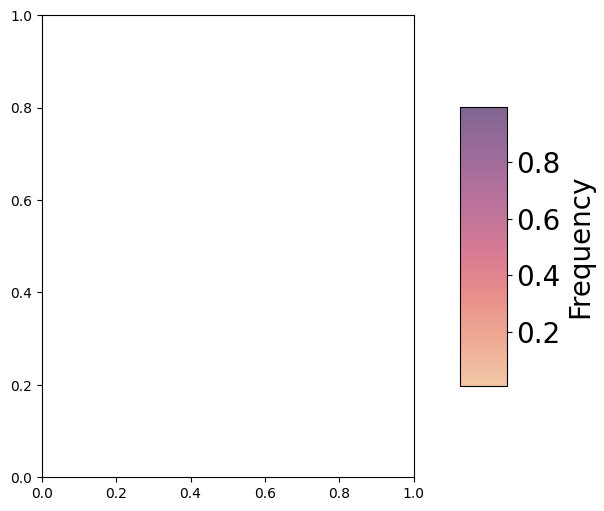

In [48]:
# Create smaller colorbar in the top right
fig, ax = plt.subplots(1, 1, figsize=(6, 6), sharey=True)  # Adjusted total figsize
colorbar = plt.colorbar(scatter, ax=ax, 
                       fraction=0.1,     # Make colorbar smaller
                       pad=0.1,           # Adjust spacing from plot
                       location='right',
                       aspect=6) 
colorbar.set_label('Frequency', fontsize=fontsize)
colorbar.ax.tick_params(labelsize=labelsize)

if SAVE_FIGS:
    fig.savefig(os.path.join(plots_path, "best_r_eta_colorbar.jpg"), dpi=1000, bbox_inches='tight')